### Import dependencies

In [1]:
import sys
import os
import json
import copy
import yaml
import datetime


from contextual_long_term_reasoning.mind_palace_generation import SceneGraph, LoadingHabitatSceneGraph, LoadingIsaacSceneGraph
from contextual_long_term_reasoning.belief_manager import WorldModel, BeliefManager
from contextual_long_term_reasoning.eqa_reasoning import EQAReasoning
from contextual_long_term_reasoning.mind_palace_exploration import MindPalaceExploration
from contextual_long_term_reasoning.eqa_evaluation import EQAEvaluation
# from contextual_long_term_reasoning.ram_interface import RecognizeAnything

### Put the path of the LA EQA Benchmark

In [2]:
# Define the file path
eqa_file_path = "../la_eqa_benchmark/eqa-questions.json"
episode_name_path = "../la_eqa_benchmark/scene-episode-names.json"

# Load the JSON file
with open(eqa_file_path, "r") as file:
    eqa_questions = json.load(file)

with open(episode_name_path, "r") as file:
    episode_names = json.load(file)

### Select the questions

In [3]:
test_one_question = True
selected_question_sets = eqa_questions[0:1] if test_one_question else eqa_questions
selected_question_sets

[{'question': 'Where did I place the orange juice after breakfast two days ago?',
  'category': 'past',
  'question_id': 'hbt_92_1',
  'scene_name': '092-hm3d-eF36g7L6Z9M',
  'answer': 'On the kitchen counter',
  'best_path': [],
  'start_place': 54}]

### Create result directory

In [4]:
b_load_pkl = True # Load the place_nodes.pkl file
b_run_RAM = not b_load_pkl  # Run RAM to recognize objects for the first time
b_save_the_logs = False # Save the logs

result_name = "ours"

if not os.path.exists("../results/" + result_name):
    os.makedirs("../results/" + result_name)


### Run the evaluation


 ##### Question ID: hbt_92_1 
 ##### Question: Where did I place the orange juice after breakfast two days ago? 
 ##### Type: past
Loading scene: 092-hm3d-eF36g7L6Z9M_0
place_nodes loaded from 'place_nodes.pkl'
Created room_node with ID r1.
Created room_node with ID r2.
Created room_node with ID r3.
Created room_node with ID r4.
Created room_node with ID r5.
Room Node r1
Room Name: Living room downstairs
Position: [2.741932690143585, -3.4702470302581787, 2.8309609293937683]
Text Object Seen: ['shiplap wall', 'side table.', 'wooden cabinet', 'shiplap walls', 'decorative items', 'wall decor.', 'large windows', 'small pillow', 'ceiling lights.', 'light switch.', 'ceiling lights', 'woven basket', 'light switch', 'light switches', 'black door', 'wooden floor', 'floor lamp', 'rug', 'wall paneling', 'bench', 'gray sofa', 'wooden bench', 'dark door', 'blanket', 'staircase', 'coffee table', 'hooks', 'teapot', 'coat hooks', 'windows', 'thermostat', 'nightstand', 'open shelves', 'wooden ceiling'

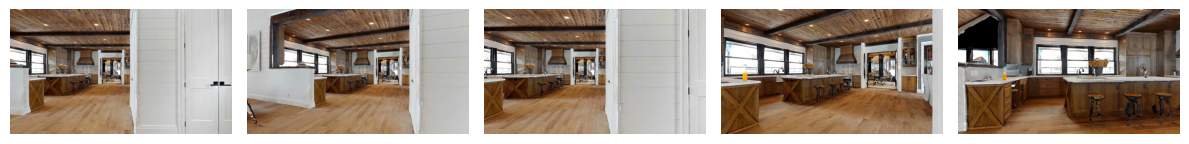

MindPalaceExploration: VLM Image Analysis Answer:  ['T', 'r', 'u', 'e']
MindPalaceExploration: VLM Image Analysis Reasoning:  There is a bottle of orange juice visible on the kitchen counter in the images.

### Episode Exploration Iteration: 2

Episode to explore:  thursday morning

## Episode Exploration Iteration: 2, Room Exploration Iteration: 1/5

RoomExploration Room list:  ['kitchen and dining']
RoomExploration Room id:  ['r5']
RoomExploration Room probability:  [0.99]
RoomExploration Reasoning:  Based on the past exploration, the orange juice was last seen on the kitchen counter in the kitchen and dining room two days ago, which was Thursday morning. Since there is no new information or exploration data indicating that the orange juice has been moved, the highest probability of finding it remains in the kitchen and dining room. Other rooms have a lower probability because there is no evidence or past observation suggesting the presence of orange juice in those locations.
RoomExp

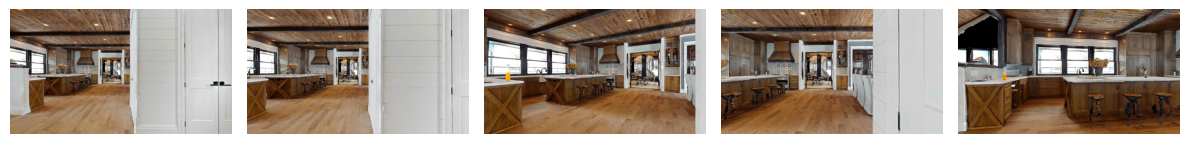

MindPalaceExploration: VLM Image Analysis Answer:  ['T', 'r', 'u', 'e']
MindPalaceExploration: VLM Image Analysis Reasoning:  The orange juice is visible on the counter in the third and fifth images.

##### Reasoning Iteration: 2

EQA Reasoning check_ready_to_answer Output: 
 { "ready_to_answer": "yes", "answer_or_explanation": "The orange juice was placed on the kitchen counter after breakfast two days ago, as it is visible in the images captured on Thursday morning." } 

Ready to answer the question!
EQA Reasoning: observation_image_paths:  ['/home/fadhil/habitat/contextual_long_term_reasoning/open_eqa_data/frames/hm3d-v0/092-hm3d-eF36g7L6Z9M_3/00222-rgb.png', '/home/fadhil/habitat/contextual_long_term_reasoning/open_eqa_data/frames/hm3d-v0/092-hm3d-eF36g7L6Z9M_3/00237-rgb.png', '/home/fadhil/habitat/contextual_long_term_reasoning/open_eqa_data/frames/hm3d-v0/092-hm3d-eF36g7L6Z9M_3/00249-rgb.png', '/home/fadhil/habitat/contextual_long_term_reasoning/open_eqa_data/frames/hm3d-v0/092-h

In [ ]:
results = {}

if b_save_the_logs:
    # Save the logs in the file
    original_stdout = sys.stdout
    # Name the file with the date, time
    now = datetime.datetime.now()
    f = open("../results/" + result_name + "/1_results_" + now.strftime("%Y-%m-%d_%H-%M-%S") + ".txt", "w")
    sys.stdout = f

prev_scene_name = ""
for question_set in selected_question_sets:
    question = question_set["question"]
    GT_A_answer = question_set["answer"]
    GT_best_path = question_set["best_path"]
    question_type = question_set["category"]
    # GT_minimal_image_retrieval = question_set["relevant_images"]
    robot_start_place = question_set["start_place"]
    scene_name = question_set["scene_name"]
    question_id = question_set["question_id"]
    episode_name_list = episode_names[scene_name]
    if "hbt_" in question_id:
        dataset_type = "habitat"
    elif "isc_" in question_id:
        dataset_type = "isaac"

    result_file_path = os.path.join("../results/" + result_name, question_id + ".yaml")

    # If the result path is there, skip
    if os.path.exists(result_file_path):
        print(f"Result file {result_file_path} already exists. Skip this question.")
        continue

    print(f"\n ##### Question ID: {question_id} \n ##### Question: {question} \n ##### Type: {question_type}")

    
    if prev_scene_name == scene_name:
        print("Same scene as previous question. Skip loading the scene.")
    else:
        # 1 Dataset definition
        if dataset_type == "habitat":
            # Dataset paths
            state_dataset_dir = "../la_eqa_benchmark/state/hm3d-v0"
            frames_dataset_dir = "../la_eqa_benchmark/frames/hm3d-v0"
            caption_dataset_dir = "../la_eqa_benchmark/captions/hm3d-v0"

            temporal_scene_name_dict = {}
            for episode_name in episode_name_list:
                temporal_scene_name_dict[episode_name] = scene_name + "_" + str(episode_name_list.index(episode_name))

            state_dataset_path = os.path.join(state_dataset_dir, scene_name)
            frames_dataset_path = os.path.join(frames_dataset_dir, scene_name)
        elif dataset_type == "isaac":
            dataset_dir = '../la_eqa_benchmark/isaac_warehouse'

            temporal_scene_name_dict = {}
            for episode_name in episode_name_list:
                temporal_scene_name_dict[episode_name] = scene_name + "_" + str(episode_name_list.index(episode_name))

            
        # 2 Mind palace generation
        mind_palace = {}

        if b_run_RAM:
            recognize_anything_model = RecognizeAnything()
        else:
            recognize_anything_model = None

        if dataset_type == "habitat":
            for time_id, sn in temporal_scene_name_dict.items():
                print(f"Loading scene: {sn}")
                hbt_scene_loader = LoadingHabitatSceneGraph(sn, frames_dataset_dir, state_dataset_dir, 
                                                            recognize_anything_model, caption_dataset_dir)
                
                place_nodes = hbt_scene_loader.load_place_nodes(b_run_RAM, b_load_pkl)
                room_nodes = hbt_scene_loader.load_room_nodes(place_nodes)
                scene_graph = SceneGraph(sn, state_dataset_dir, room_nodes=room_nodes, place_nodes=place_nodes)
                mind_palace[time_id] = scene_graph

                print(scene_graph.print_room_nodes())

        elif dataset_type == "isaac":
            for time_id, sn in temporal_scene_name_dict.items():
                print(f"Loading scene: {sn}")
                isaac_scene_loader = LoadingIsaacSceneGraph(dataset_dir, sn, recognize_anything_model)
                
                place_nodes = isaac_scene_loader.load_place_nodes(b_run_RAM, b_load_pkl)
                room_nodes = isaac_scene_loader.load_room_nodes(place_nodes)
                scene_graph = SceneGraph(sn, os.path.join(dataset_dir, sn, 'state/'), room_nodes=room_nodes, place_nodes=place_nodes)
                mind_palace[time_id] = scene_graph

    # If we don't load old pkl, return
    if not b_load_pkl:
        break
        
    # 3 Main loop
    # Main algorithm
    # 0. Initialize belief
    belief_manager = BeliefManager(question, mind_palace)
    world_model = WorldModel(mind_palace)
    robot_place = copy.deepcopy(robot_start_place)

    # 1. EQA reasoning and 2. Mind Palace Exploration
    eqa_reasoning = EQAReasoning()
    mind_palace_exploration = MindPalaceExploration()

    # Params
    max_reasoning_iter = 2
    max_episode_exploration_iter = 4
    max_room_exploration_iter = 5
    max_num_place_node_exploration = 10

    # Stats
    stats_total_images_retrieved = 0
    stats_total_distance = 0

    reasoning_iter = 1
    while reasoning_iter <= max_reasoning_iter:
        print(f"\n##### Reasoning Iteration: {reasoning_iter}\n")
        # 1. EQA reasoning

        # 1.a. (Answer check) : Given Q, Memory/Belief(all the images retrieved so far and textual insight from the images), 
        # do we have enough information to answer the question? 
        bool_ready_to_answer, explanation = eqa_reasoning.check_ready_to_answer(belief_manager)
        belief_manager.S_EQA_reasoning_summary.append("Reasoning Iteration: " + str(reasoning_iter) + ":\n" + explanation + "\n")
        if bool_ready_to_answer:
            print("Ready to answer the question!")
            break
        
        

        # 1.b If (Answer check) EQA Reasoning is No, do (Object identification) -> target object y : 
        # Given Q, Memory/Belief(all the images retrieved so far and textual insight from the images), 
        # What object/conceptual things that I need to look for in the environment to help answer the question? (For our example, black wallet),
        belief_manager.y_object_to_search, belief_manager.y_reasoning_to_search_object = eqa_reasoning.object_identification(belief_manager)
        belief_manager.S_EQA_reasoning_summary.append("Reasoning Iteration: " + str(reasoning_iter) + "Object to search: " + str(belief_manager.y_object_to_search) + " " + str(belief_manager.y_reasoning_to_search_object) + "\n")  

        # 2. Mind Palace Exploration
        # Given Q, Memory/Belief(all the images retrieved so far and textual insight from the images), 
        # What action (explore(pX) or retrieve(TX, pX)) that I need to do to find the target object y
        # 	2.a.1 level_3_episode_selection -> TX # max exploration iter
        T_episode_to_explore = mind_palace_exploration.episodic_exploration.plan(belief_manager)
        list_T_episode_to_explore, search_strategy, reasoning_on_search_strategy, reasoning = mind_palace_exploration.episodic_exploration.episodic_reasoning_v2(belief_manager)
        belief_manager.S_EQA_reasoning_summary.append("Reasoning Iteration: " + str(reasoning_iter) + ":\n Episodic Search Strategy: \n" + str(search_strategy) + str(reasoning_on_search_strategy) + "\nEpisode to explore " + str(list_T_episode_to_explore) + str(reasoning) + "\n")
        
        episode_exploration_iter = 1


        for T_episode_to_explore_seq in list_T_episode_to_explore:
            T_episode_now = belief_manager.get_now_episode()

            if episode_exploration_iter <= max_episode_exploration_iter:
                print(f"\n### Episode Exploration Iteration: {episode_exploration_iter}\n")
                print("Episode to explore: ", T_episode_to_explore)
            else:
                print("Max episode exploration iteration reached. We will stop the exploration.")
                break

            if stats_total_images_retrieved > 100:
                print("Max number of images retrieved reached. We will stop the exploration.")
                break

            bool_y_object_found = False
            # 2.a (Object search) MindPalaceExploration -> action “a”: 

            room_exploration_iter = 1
            
            belief_manager.reset_room_and_place_exploration_memory()
            while room_exploration_iter <= max_room_exploration_iter:
                print(f"\n## Episode Exploration Iteration: {episode_exploration_iter}, Room Exploration Iteration: {room_exploration_iter}/{max_room_exploration_iter}\n")
                # 	2.a.2 level_2_room_selection -> rX # Can be multiple times # max room exploration iter
                # 	2.a.3 level_1_pose_selection -> pX # Only 1 time
                r_room_to_explore, b_single_now_explore_plan = mind_palace_exploration.room_exploration.plan(belief_manager, T_episode_to_explore, robot_place)

                text_image_insight = ""
                num_explored_places = 0
                
                while num_explored_places < max_num_place_node_exploration:
                    print(f"\n# Episode Exploration Iteration: {episode_exploration_iter}, Room Exploration Iteration: {room_exploration_iter}, Place Exploration Iteration: {num_explored_places}/{max_num_place_node_exploration}\n")
                    print("Room to explore: ", r_room_to_explore)
                    p_goal_poses = mind_palace_exploration.place_exploration.plan(belief_manager, T_episode_to_explore, r_room_to_explore) # Can be multiple poses, consider doing it one by one for exploration

                    if len(p_goal_poses) == 0:
                        print("No other place to explore from LLM answer. We will explore other room.")
                        break

                    # 2.b (Exploration): Execute action “a” (explore(pX) or retrieve(TX, pX)), 
                    # get an image from the pose pX. in world model
                    observed_images, image_paths = world_model.explore(T_episode_to_explore, p_goal_poses)
                    if 'now' in T_episode_to_explore:
                        robot_place, distance = world_model.move_robot(T_episode_to_explore, robot_place, p_goal_poses)
                        stats_total_distance += distance
                    stats_total_images_retrieved += len(image_paths) if "now" not in T_episode_to_explore else 0


                    if len(image_paths) == 0:
                        print("No image retrieved. We will explore other room.")
                        break


                    # 2.c (VLM Inference): Given the image. In belief manager
                    # 2.c.1 Query VLM: Do we see the target object y?
                    # 2.c.2 Query VLM: If yes, also ask VLM to describe the image in relation to answering the question and 
                    bool_y_object_found, text_image_insight = mind_palace_exploration.vlm_image_analysis(image_paths, belief_manager)

                    # If target object y found is yes:
                    # 2.c.3 Add image and insight to the belief/memory.
                    if bool_y_object_found:
                        belief_manager.update_history(text_image_insight,
                                                    observed_images, image_paths,
                                                    T_episode_to_explore,
                                                    r_room_to_explore,
                                                    p_goal_poses) # todo add more room, location, time
                        break
                    
                    belief_manager.update_place_exploration_memory(p_goal_poses)
                    num_explored_places = len(belief_manager.H_a_place_exploration_action_history)

                if bool_y_object_found:
                    break
                
                belief_manager.update_room_exploration_memory(text_image_insight, T_episode_to_explore, r_room_to_explore)

                room_exploration_iter += 1

                if stats_total_images_retrieved > 100:
                    print("Max number of images retrieved reached. We will stop the exploration.")
                    break

            # To avoid break loop in memory consolidation we comment this
            # if bool_y_object_found:
            #     break
            if bool_y_object_found is False:
                belief_manager.S_EQA_reasoning_summary.append("Reasoning Iteration: " + str(reasoning_iter) + "The target object " + str(belief_manager.y_object_to_search) + " is not found in the episode: " + str(T_episode_to_explore) + "\n")
            
            episode_exploration_iter += 1

        reasoning_iter += 1

    # Answer regardless of the readiness
    A_answer, reasoning_to_the_answer = eqa_reasoning.answer_the_question(belief_manager)
    print("Answer: ", A_answer)
    print("Reasoning: ", reasoning_to_the_answer)

    # 4 Evaluation
    eqa_evaluation = EQAEvaluation(question, robot_start_place, 
                                   GT_A_answer, GT_best_path)
    # Evaluate the answer accuracy
    answer_accuracy = eqa_evaluation.evaluate_answer_accuracy(A_answer)

    # Evaluate the SPL
    SPL = eqa_evaluation.evaluate_SPL(belief_manager, world_model, stats_total_distance) 

    # Evaluate the retrieval precision
    number_retrieved_images = eqa_evaluation.count_retrieved_images(belief_manager)

    print("Answer accuracy: ", answer_accuracy, "(1-5)")
    print("SPL: ", SPL)
    print("Number of retrieved images: ", number_retrieved_images)

    result = {}
    result["question_id"] = question_id
    result["question"] = question
    result["question_type"] = question_type
    result["GT_A_answer"] = GT_A_answer
    result["GT_best_path"] = GT_best_path
    result["A_answer"] = A_answer
    result["reasoning_to_the_answer"] = reasoning_to_the_answer
    result["answer_accuracy"] = answer_accuracy
    result["distance_traveled"] = stats_total_distance
    result["total_images_retrieved"] = stats_total_images_retrieved
    result["SPL"] = SPL
    result["reasoning_summary"] = belief_manager.S_EQA_reasoning_summary

    # Save the result to a line of an existing csv file
    result_csv_file_path = os.path.join("../results", result_name, "results.csv")
    with open(result_csv_file_path, "a") as file:
        file.write(f"{question_id},{question_type},{question.replace(',', '')},{GT_A_answer.replace(',', '')},{str(GT_best_path).replace(',', '')},{A_answer.replace(',', '')},{answer_accuracy},{stats_total_distance},{stats_total_images_retrieved},{SPL}\n")

    # Save the result in yaml file as well
    result_file_path = os.path.join("../results/" + result_name, question_id + ".yaml")
    with open(result_file_path, "w") as file:
        yaml.dump(result, file, default_flow_style=False)

    results[question_id] = result

    prev_scene_name = scene_name

# Name with the date, time
now = datetime.datetime.now()
result_file_path = os.path.join("../results/" + result_name, "1_results_" + now.strftime("%Y-%m-%d_%H-%M-%S") + ".json")
with open(result_file_path, "w") as file:
    json.dump(results, file)


if b_save_the_logs:
    # Restore original stdout
    sys.stdout = original_stdout

    # Close the file
    f.close()
